# Instacart Basket Analysis

1. Used Data (Base Line):
    1. [https://github.com/KazukiOnodera/Instacart](https://github.com/KazukiOnodera/Instacart) 
    2. [https://www.kaggle.com/charalambos/xgb-of-instacart-ml-2-notebook](https://www.kaggle.com/charalambos/xgb-of-instacart-ml-2-notebook) → Baseline 모델로 이용
    3. [https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart/notebook](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-instacart/notebook()) → Visaulization 및 EDA 참고
2. Problem : 
Predict which previously purchased products will be in a user’s next order.<br>
    1. 특정 고객이 가진 주문정보 만으로는 그 수가 적어 제대로 된 예측을 할 수 없다. ( 약 15개의 주문정보 뿐) 전체 고객의 확률분포를 가지고 특정 고객의 확률분포를 이용하는 것은 문제가 많아(고객의 특성을 반영하지 못함). 이를 해결하고자, 표본집단이 얼마나 모집단을 잘 대표하는지 대표성을 구하고자 하였습니다. 따라서, 어떤 고객의 특성을 잘 대변하는 집단으로 묶어서 그 집단의 확률을 구한다면 좀 더 잘 대표하지 않을까 생각하였습니다.
    2. 결국 특정 손님이 이 물건을 미래 구매 여부를 예측하는 문제다. 이를 추론하기 위해선 이 손님이 정보를 알고 있는 손님과 얼마나 유사하게 제품을 구매 하는 지를 이용하여 → 특정 집단에 속하는 고객이라면 다음 물품은 어떤 것을 구매할 확률이 높다고 가설을 세웠습니다.
    
3. Feature selection : 
|   | Category       | Variable Name                              | Formula & Features                                                                                                                                                                        |
|----|----------------|---------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1  | user           | Times_Bought_N                        | dataset.groupby(['user_id', 'product_id'])[['order_id']].count()<br/>유저가 산 특정 상품의 총 주문 횟수                                                                                              |
| 2  | user           | total_orders                          | dataset.groupby('user_id')['order_number'].max()<br/>유저별 총 주문 횟수                                                                                                                       |
| 3  | user x product | uxp_reorder_ratio                     | dataset.Times_Bought_N / dataset.total_orders-dataset.first_order_number+1<br/>유저가 첫주문 이후 특정 상품을 재주문 할 확률                                                                              |
| 4  | user           | u_reordered                           | dataset.groupby(['user_id'])['reordered'].aggregate('mean')<br/>유저가 재주문할 확률                                                                                                            |
| 5  | product        | product_total_purchases               | dataset.groupby('product_id')['order_id'].count()<br/>상품이 총 팔린 횟수                                                                                                                      |
| 6  | product        | p_reorder_ratio                       | dataset.groupby('product_id')['reordered'].mean()<br/>상품별 재주문될 평균 확률                                                                                                                   |
| 7  | -              | eval_set                              | 평가 set                                                                                                                                                                                 |
| 8  | -              | order_id                              | 주문 id                                                                                                                                                                                  |
| 9  | time           | order_hour_of_day                     | 상품 구매한 시각                                                                                                                                                                              |
| 10 | time           | order_dow                             | 상품을 주문한 요일 (기본 데이터셋)                                                                                                                                                                   |
| 11 | product        | aisle_id                              | aisle id                                                                                                                                                                               |
| 12 | product        | department_id                         | department_id                                                                                                                                                                          |
| 13 | product        | mean_position                         | dataset.groupby('product_id')['add_to_cart_order'].mean().reset_index(name = 'mean_position')<br/>상품이 카트에 추가 되는 순서 평균                                                                  |
| 14 | product        | dept_rodrder_rate                     | dataset.groupby('department')['reordered'].mean()<br/>품목별 재주문 확률                                                                                                                       |
| 15 | product        | aisle_reorder_reate                   | dataset.groupby('aisle')['reordered'].mean() <br/>aisle재주문 확률                                                                                                                          |
| 16 | product        | dow_reordered                         | dataset.groupby('order_dow')['reordered'].mean() <br/>요일 별 재주문 확률                                                                                                                      |
| 17 | product        | dow_aisle_reordered                   | dataset.groupby(['order_dow', 'aisle_id'])['reordered'].mean()<br/>요일에 따른 ailsle 재주문 확률                                                                                                |
| 18 | product        | dow_dept_reordered                    | dataset.groupby(['departmet_id', 'aisle_id'])['reordered'].mean() <br/>요일에 따른 품목 재주문 확률                                                                                                |
| 19 | product        | dept_percentage                       | dataset['department_id'].value_counts().to_frame('dept_percentage').reset_index()<br/>dept_percentage['dept_percentage']/sum(dept_percentage['dept_percentage'])<br/>품목별 주문확률          |
| 20 | time           | dow_hour_rorder                       | dataset.groupby(['order_dow', 'order_hour_of_day'])['reordered'].mean()<br/>요일과 시간에 따른 재주문 확률                                                                                          |
| 21 | prodct         | product_roredered_dow                 | dataset.groupby(['product_id','order_dow'])["reordered"].mean()<br/>요일별 특정 상품의 재주문 확률                                                                                                  |
| 22 | product        | prod_rordered_hod                     | dataset.groupby(['product_id','order_hour_of_day'])["reordered"].mean()<br/> 시간별 특정 상품의 재주문 확률                                                                                         |
| 23 | time           | day_reorder_rate                      | df = prior_data.groupby(['product_id','order_dow'])["product_id"].size()<br/>df = df/prior_data.groupby(["product_id"]).size() #특정 상품의 총 주문량<br/>요일별 특정 상품 주문량/ 특정 상품 총 주문량            |
| 24 | time           | hour_reorder_rate                     |  df = prior_data.groupby(['product_id','order_hour_of_day'])["reordered"].size()<br/> df = df/prior_data.groupby(["product_id"]).size()<br/>시간별 특정 상품 주문량/특정 상품 총 주문량                  |
| 25 | time           | p_days_since_prior_order_reorder_rate | df = prior_data.groupby(['product_id','days_since_prior_order'])["reordered"].size()<br/>df = df/prior_data.groupby(["product_id"]).size()<br/>상품별 다음 재주문시 걸리는 날짜의 확률                  |
| 26 | time           | days_since_prior_order                | 주문 이후 재주문 하는 일수                                                                                                                                                                        |
| 27 | time               | days_since_prior_reorder_rate         | df = prior_data.groupby(["user_id","product_id","days_since_prior_order"])["reordered"].size()<br/>df = df/prior_data.groupby(["user_id","product_id"]).size()<br/>특정 상품을 주문후 재주문하는 확률 |
    
    
4. Model : XGBoost
5. Score  <br>
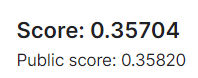

In [6]:
#Importing useful libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sys
import os
color = sns.color_palette()
%matplotlib inline
# Garbage Collector to free up memory
import gc                         
gc.enable()

## Insta Cart Toy Project
- EDA
- Visulaization
- Analysis
- Train
- Result

In [7]:
# Data load
aisles = pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/aisles.csv')
departments= pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/departments.csv')
order_prod_prior =pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/order_products__prior.csv')

order_prod_train =pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/order_products__train.csv')
orders =pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/orders.csv')
products = pd.read_csv('/home/jovyan/nas/1_user/hjlee@agilesoda.ai/Instacart/products.csv')

## 1. EDA

In [4]:
# aisles.describe()
# order_prod_prior.describe()
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


In [5]:
display(order_prod_prior)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [6]:
display(orders)
display(orders[(orders['user_id'] == 1)])
display(orders[(orders['order_id']==2539329)])

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN


In [8]:
# make main dataset
all_join = pd.merge(left = order_prod_prior, right = orders , how = 'left', on ='order_id')
all_join = pd.merge(left = all_join, right = products , how = 'left', on ='product_id')
all_join = pd.merge(left = all_join, right = aisles , how = 'left', on ='aisle_id')
all_join = pd.merge(left = all_join, right = departments , how = 'left', on ='department_id')
display(all_join)
display(order_prod_prior)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,3421083,39678,6,1,25247,prior,24,2,6,21.0,Free & Clear Natural Dishwasher Detergent,74,17,dish detergents,household
32434485,3421083,11352,7,0,25247,prior,24,2,6,21.0,Organic Mini Sandwich Crackers Peanut Butter,78,19,crackers,snacks
32434486,3421083,4600,8,0,25247,prior,24,2,6,21.0,All Natural French Toast Sticks,52,1,frozen breakfast,frozen
32434487,3421083,24852,9,1,25247,prior,24,2,6,21.0,Banana,24,4,fresh fruits,produce


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


## User Frequency
1. Hard coding
2. Clean code

In [46]:
# frequency of reorder for each user ex). user_id = 1
# all_join[(all_join['product_id']==196)&(all_join['user_id']==1)].count()
user1_reorder=all_join[(all_join['reordered']==1)&(all_join['user_id']==1)].user_id.count()
user1_total_order = all_join[(all_join['user_id']==1)].user_id.count()
user1_reorder_frequency = user1_reorder/user1_total_order
print(user1_reorder_frequency)

0.6949152542372882


In [47]:
user_reorder=all_join[(all_join['reordered']==1)].groupby('user_id').product_id.count()
user_order=all_join.groupby('user_id').product_id.count()
user_reorder_frequency = user_reorder.div(user_order, fill_value=0)
# user_reorder_frequency = user_reorder/user_order
# display(user_reorder)

In [48]:
user_reorder_frequency.count()

206209

In [49]:
user_order.count()

206209

In [50]:
user_reorder.count()

203164

In [9]:
# 2. Clean code
grouped_frequency = all_join.groupby(['user_id'])['reordered'].mean().to_frame('u_reordered')
grouped_frequency

,u_reordered
user_id,
1,0.694915
2,0.476923
3,0.625000
4,0.055556
5,0.378378
...,...
206205,0.250000
206206,0.473684
206207,0.587444


In [10]:
user = grouped_frequency
user.head()

,u_reordered
user_id,
1,0.694915
2,0.476923
3,0.625000
4,0.055556
5,0.378378


In [11]:
# Most purchased products
# Products purchased
products_purchased = all_join.groupby('product_id')['order_id'].count().to_frame('product_total_purchases')
products_purchased

,product_total_purchases
product_id,
1,1852
2,90
3,277
4,329
5,15
...,...
49684,9
49685,49
49686,120


In [12]:
# For individual marketing which product did user buy
times = all_join.groupby(['user_id', 'product_id'])[['order_id']].count()
times.columns = ['Times_Bought_N']
times.head()

Times_Bought_N
user_id product_id                
1       196                     10
        10258                    9
        10326                    1
        12427                   10
        13032                    3

In [13]:
# user's total orders: order_number's max
total_orders = all_join.groupby('user_id')['order_number'].max().to_frame('total_orders')
total_orders

,total_orders
user_id,
1,10
2,14
3,12
4,5
5,4
...,...
206205,3
206206,67
206207,16


In [14]:
# To find when users ordered their products at the first time (at this point because of goupby func row 3million ->1.3million)
first_order_no = all_join.groupby(['user_id', 'product_id'])['order_number'].min().to_frame('first_order_number')
first_order_no  = first_order_no.reset_index()
first_order_no

,user_id,product_id,first_order_number
0,1,196,1
1,1,10258,2
2,1,10326,5
3,1,12427,1
4,1,13032,2
...,...,...,...
13307948,206209,43961,4
13307949,206209,44325,7
13307950,206209,48370,11
13307951,206209,48697,7


In [15]:
# mean ratio of the _total
p_reorder = all_join.groupby('product_id')['reordered'].mean().to_frame('p_reorder_ratio')
p_reorder

,p_reorder_ratio
product_id,
1,0.613391
2,0.133333
3,0.732852
4,0.446809
5,0.600000
...,...
49684,0.111111
49685,0.122449
49686,0.700000


In [16]:
span = pd.merge(total_orders, first_order_no, on='user_id', how='right')
span

,user_id,total_orders,product_id,first_order_number
0,1,10,196,1
1,1,10,10258,2
2,1,10,10326,5
3,1,10,12427,1
4,1,10,13032,2
...,...,...,...,...
13307948,206209,13,43961,4
13307949,206209,13,44325,7
13307950,206209,13,48370,11
13307951,206209,13,48697,7


In [17]:
span['Order_Range_D'] = span.total_orders - span.first_order_number + 1
span

,user_id,total_orders,product_id,first_order_number,Order_Range_D
0,1,10,196,1,10
1,1,10,10258,2,9
2,1,10,10326,5,6
3,1,10,12427,1,10
4,1,10,13032,2,9
...,...,...,...,...,...
13307948,206209,13,43961,4,10
13307949,206209,13,44325,7,7
13307950,206209,13,48370,11,3
13307951,206209,13,48697,7,7


In [18]:
uxp_ratio = pd.merge(times, span, on=['user_id', 'product_id'], how='left')
uxp_ratio

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D
0,1,196,10,10,1,10
1,1,10258,9,10,2,9
2,1,10326,1,10,5,6
3,1,12427,10,10,1,10
4,1,13032,3,10,2,9
...,...,...,...,...,...,...
13307948,206209,43961,3,13,4,10
13307949,206209,44325,1,13,7,7
13307950,206209,48370,1,13,11,3
13307951,206209,48697,1,13,7,7


In [19]:
uxp_ratio['uxp_reorder_ratio'] = uxp_ratio.Times_Bought_N / uxp_ratio.Order_Range_D
uxp_ratio

,user_id,product_id,Times_Bought_N,total_orders,first_order_number,Order_Range_D,uxp_reorder_ratio
0,1,196,10,10,1,10,1.000000
1,1,10258,9,10,2,9,1.000000
2,1,10326,1,10,5,6,0.166667
3,1,12427,10,10,1,10,1.000000
4,1,13032,3,10,2,9,0.333333
...,...,...,...,...,...,...,...
13307948,206209,43961,3,13,4,10,0.300000
13307949,206209,44325,1,13,7,7,0.142857
13307950,206209,48370,1,13,11,3,0.333333
13307951,206209,48697,1,13,7,7,0.142857


In [20]:
uxp_ratio = uxp_ratio.drop(['first_order_number', 'Order_Range_D'], axis=1)
uxp_ratio

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio
0,1,196,10,10,1.000000
1,1,10258,9,10,1.000000
2,1,10326,1,10,0.166667
3,1,12427,10,10,1.000000
4,1,13032,3,10,0.333333
...,...,...,...,...,...
13307948,206209,43961,3,13,0.300000
13307949,206209,44325,1,13,0.142857
13307950,206209,48370,1,13,0.333333
13307951,206209,48697,1,13,0.142857


In [539]:
# del [times, first_order_no, span]

In [21]:
data = uxp_ratio.merge(user, on='user_id', how='left')
data

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered
0,1,196,10,10,1.000000,0.694915
1,1,10258,9,10,1.000000,0.694915
2,1,10326,1,10,0.166667,0.694915
3,1,12427,10,10,1.000000,0.694915
4,1,13032,3,10,0.333333,0.694915
...,...,...,...,...,...,...
13307948,206209,43961,3,13,0.300000,0.472868
13307949,206209,44325,1,13,0.142857,0.472868
13307950,206209,48370,1,13,0.333333,0.472868
13307951,206209,48697,1,13,0.142857,0.472868


In [22]:
data = data.merge(products_purchased, on='product_id', how='left')
data

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases
0,1,196,10,10,1.000000,0.694915,35791
1,1,10258,9,10,1.000000,0.694915,1946
2,1,10326,1,10,0.166667,0.694915,5526
3,1,12427,10,10,1.000000,0.694915,6476
4,1,13032,3,10,0.333333,0.694915,3751
...,...,...,...,...,...,...,...
13307948,206209,43961,3,13,0.300000,0.472868,55371
13307949,206209,44325,1,13,0.142857,0.472868,3485
13307950,206209,48370,1,13,0.333333,0.472868,3934
13307951,206209,48697,1,13,0.142857,0.472868,9783


In [23]:
data['product_total_purchases'] = data['product_total_purchases'].fillna(value=0)

In [24]:
data = data.merge(p_reorder, on='product_id', how='left')
data

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio
0,1,196,10,10,1.000000,0.694915,35791,0.776480
1,1,10258,9,10,1.000000,0.694915,1946,0.713772
2,1,10326,1,10,0.166667,0.694915,5526,0.652009
3,1,12427,10,10,1.000000,0.694915,6476,0.740735
4,1,13032,3,10,0.333333,0.694915,3751,0.657158
...,...,...,...,...,...,...,...,...
13307948,206209,43961,3,13,0.300000,0.472868,55371,0.630583
13307949,206209,44325,1,13,0.142857,0.472868,3485,0.401148
13307950,206209,48370,1,13,0.333333,0.472868,3934,0.699288
13307951,206209,48697,1,13,0.142857,0.472868,9783,0.357661


In [25]:
data

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio
0,1,196,10,10,1.000000,0.694915,35791,0.776480
1,1,10258,9,10,1.000000,0.694915,1946,0.713772
2,1,10326,1,10,0.166667,0.694915,5526,0.652009
3,1,12427,10,10,1.000000,0.694915,6476,0.740735
4,1,13032,3,10,0.333333,0.694915,3751,0.657158
...,...,...,...,...,...,...,...,...
13307948,206209,43961,3,13,0.300000,0.472868,55371,0.630583
13307949,206209,44325,1,13,0.142857,0.472868,3485,0.401148
13307950,206209,48370,1,13,0.333333,0.472868,3934,0.699288
13307951,206209,48697,1,13,0.142857,0.472868,9783,0.357661


In [64]:
orders_future = orders[((orders.eval_set=='train') | (orders.eval_set=='test'))]
orders_future = orders_future[ ['user_id', 'eval_set', 'order_id'] ]

In [27]:
orders_future

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797
...,...,...,...
3420933,206205,train,1716008
3421001,206206,test,1043943
3421018,206207,test,2821651
3421068,206208,test,803273


## Add mor features
### Features
1. How many times did user bought
2. Ratio of user bought the product
3. Ratio of user's reorder percentage
4. Product information of total purchased
5. product's reordered ration


In [28]:
# bring the info of the future orders to data DF
data_1 = data.merge(orders_future, on='user_id', how='left')
data_1

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,eval_set,order_id
0,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899
1,1,10258,9,10,1.000000,0.694915,1946,0.713772,train,1187899
2,1,10326,1,10,0.166667,0.694915,5526,0.652009,train,1187899
3,1,12427,10,10,1.000000,0.694915,6476,0.740735,train,1187899
4,1,13032,3,10,0.333333,0.694915,3751,0.657158,train,1187899
...,...,...,...,...,...,...,...,...,...,...
13307948,206209,43961,3,13,0.300000,0.472868,55371,0.630583,train,272231
13307949,206209,44325,1,13,0.142857,0.472868,3485,0.401148,train,272231
13307950,206209,48370,1,13,0.333333,0.472868,3934,0.699288,train,272231
13307951,206209,48697,1,13,0.142857,0.472868,9783,0.357661,train,272231


In [29]:
#, 'department_id', 'aisle_id' 여기서 3000만으로 증가
new_d_set = all_join[['user_id','product_id','order_hour_of_day', 'order_dow', 'days_since_prior_order', 'department_id', 'aisle_id']]
data_1=data_1.merge(new_d_set, on=['user_id','product_id'], how= 'left')
data_1

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,eval_set,order_id,order_hour_of_day,order_dow,days_since_prior_order,department_id,aisle_id
0,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,15,4,28.0,7,77
1,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,12,3,21.0,7,77
2,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,9,1,20.0,7,77
3,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,7,4,29.0,7,77
4,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,16,1,0.0,7,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,206209,44325,1,13,0.142857,0.472868,3485,0.401148,train,272231,13,2,9.0,9,131
32434485,206209,48370,1,13,0.333333,0.472868,3934,0.699288,train,272231,10,4,30.0,17,54
32434486,206209,48697,1,13,0.142857,0.472868,9783,0.357661,train,272231,13,2,9.0,13,19
32434487,206209,48742,2,13,0.285714,0.472868,1723,0.498549,train,272231,13,2,9.0,14,130


In [30]:
# 상품이 카트에 추가 되는 순서 평균
mean_position = all_join.groupby('product_id')['add_to_cart_order'].mean().reset_index(name = 'mean_position')
#Get aisle reorder rate
aisle_reorder_rate = all_join.groupby(['aisle_id'])['reordered'].mean().reset_index(name='aisle_reorder_rate') 
#Get dept reorder rate
dept_reorder_rate = all_join.groupby(['department_id'])['reordered'].mean().reset_index(name='dept_reorder_rate')

In [31]:
# data_1 = data_1.merge(products, on=['product_id'], how='left')
data_1 = data_1.merge(mean_position, on=['product_id'], how='left')
data_1 = data_1.merge(dept_reorder_rate, on=['department_id'], how='left')
data_1 = data_1.merge(aisle_reorder_rate, on=['aisle_id'], how='left')

In [32]:
data_1

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,eval_set,order_id,order_hour_of_day,order_dow,days_since_prior_order,department_id,aisle_id,mean_position,dept_reorder_rate,aisle_reorder_rate
0,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,15,4,28.0,7,77,3.721774,0.653460,0.638832
1,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,12,3,21.0,7,77,3.721774,0.653460,0.638832
2,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,9,1,20.0,7,77,3.721774,0.653460,0.638832
3,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,7,4,29.0,7,77,3.721774,0.653460,0.638832
4,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,16,1,0.0,7,77,3.721774,0.653460,0.638832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,206209,44325,1,13,0.142857,0.472868,3485,0.401148,train,272231,13,2,9.0,9,131,10.109900,0.461076,0.453062
32434485,206209,48370,1,13,0.333333,0.472868,3934,0.699288,train,272231,10,4,30.0,17,54,8.344942,0.402178,0.528005
32434486,206209,48697,1,13,0.142857,0.472868,9783,0.357661,train,272231,13,2,9.0,13,19,8.763058,0.346721,0.350843
32434487,206209,48742,2,13,0.285714,0.472868,1723,0.498549,train,272231,13,2,9.0,14,130,7.991294,0.560922,0.499501


In [33]:
# 유저가 어떤 요일 어떤 물건을 살 확률 
dow_reordered = all_join.groupby(['order_dow'])['reordered'].mean().to_frame('dow_rordered')
# 요일별 aisle에서 재 판매되는 확률
dow_aisle_reordered = all_join.groupby(['order_dow', 'aisle_id'])['reordered'].mean().to_frame('dow_aisle_rordered').reset_index()
# 요일별 dept에서 재 판매되는 확률
dow_dept_reordered = all_join.groupby(['order_dow', 'department_id'])['reordered'].mean().to_frame('dow_dept_rordered').reset_index()

In [34]:
# dept별 분포 
dept_percentage = all_join['department_id'].value_counts().to_frame('dept_percentage').reset_index()
dept_percentage['dept_percentage']= dept_percentage['dept_percentage']/sum(dept_percentage['dept_percentage'])
dept_percentage = dept_percentage.rename(columns = {'index': 'department_id'})
# 요일별 재 구매 시간 평균
dow_hour_reorder = all_join.groupby(['order_dow', 'order_hour_of_day'])['reordered'].aggregate('mean').to_frame('dow_hour_reorder').reset_index()

In [35]:
# 각 상품의 요일별 재구매 확귤 
prod_reordered_dow = all_join.groupby(['product_id','order_dow'])["reordered"].mean().to_frame('product_reordered_dow')
# 각 상품의 시간별 재구매 확률
prod_reordered_hod = all_join.groupby(['product_id','order_hour_of_day'])["reordered"].mean().to_frame('prod_reordered_hod')

In [37]:
# prod_reordered_hod1= all_join.groupby(['product_id','order_hour_of_day'])["reordered"].mean().to_frame('prod_reordered_hod')
prod_reordered_dpo = all_join.groupby(['product_id','days_since_prior_order'])["reordered"].size()
prod_reordered_dpo = prod_reordered_dpo/all_join.groupby(["product_id"]).size()
prod_reordered_dpo = prod_reordered_dpo.reset_index(name = 'prod_reordered_dpo')

In [38]:
# merge
data_1 = data_1.merge(dow_reordered, on=['order_dow'], how='left')
data_1 = data_1.merge(dow_aisle_reordered, on=['order_dow', 'aisle_id'], how='left')
data_1 = data_1.merge(dow_dept_reordered, on=['order_dow', 'department_id'], how='left')
data_1 = data_1.merge(dept_percentage, on=['department_id'], how='left')
data_1 = data_1.merge(dow_hour_reorder, on=['order_dow', 'order_hour_of_day'], how='left')
data_1 = data_1.merge(prod_reordered_dow, on=['product_id', 'order_dow'], how='left')
data_1 = data_1.merge(prod_reordered_hod, on=['product_id', 'order_hour_of_day'], how='left')
data_1 = data_1.merge(prod_reordered_dpo, on=['product_id','days_since_prior_order'], how='left')

In [39]:
# data_1 = data_1.drop('reordered_y', axis = 1)
# data_1.rename(columns= {'reordered_y': 'reordered'})
data_1

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,eval_set,order_id,...,dept_reorder_rate,aisle_reorder_rate,dow_rordered,dow_aisle_rordered,dow_dept_rordered,dept_percentage,dow_hour_reorder,product_reordered_dow,prod_reordered_hod,prod_reordered_dpo
0,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.653460,0.638832,0.590979,0.632788,0.650271,0.082940,0.585931,0.768907,0.773451,0.010952
1,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.653460,0.638832,0.586272,0.638797,0.650482,0.082940,0.576301,0.773050,0.769180,0.017854
2,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.653460,0.638832,0.603843,0.677328,0.677451,0.082940,0.651143,0.818099,0.808148,0.014194
3,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.653460,0.638832,0.590979,0.632788,0.650271,0.082940,0.636844,0.768907,0.786026,0.007320
4,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.653460,0.638832,0.603843,0.677328,0.677451,0.082940,0.579219,0.818099,0.756458,0.027744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,206209,44325,1,13,0.142857,0.472868,3485,0.401148,train,272231,...,0.461076,0.453062,0.589771,0.446837,0.454189,0.026719,0.579582,0.422917,0.408000,0.041320
32434485,206209,48370,1,13,0.333333,0.472868,3934,0.699288,train,272231,...,0.402178,0.528005,0.590979,0.539190,0.407662,0.022774,0.594672,0.692149,0.725000,0.094814
32434486,206209,48697,1,13,0.142857,0.472868,9783,0.357661,train,272231,...,0.346721,0.350843,0.589771,0.357642,0.350453,0.057827,0.579582,0.354680,0.343137,0.032301
32434487,206209,48742,2,13,0.285714,0.472868,1723,0.498549,train,272231,...,0.560922,0.499501,0.589771,0.496570,0.559150,0.021877,0.579582,0.433962,0.453846,0.034823


In [41]:
data_1.isnull().sum()

user_id                          0
product_id                       0
Times_Bought_N                   0
total_orders                     0
uxp_reorder_ratio                0
u_reordered                      0
product_total_purchases          0
p_reorder_ratio                  0
eval_set                         0
order_id                         0
order_hour_of_day                0
order_dow                        0
days_since_prior_order     2078068
department_id                    0
aisle_id                         0
mean_position                    0
dept_reorder_rate                0
aisle_reorder_rate               0
dow_rordered                     0
dow_aisle_rordered               0
dow_dept_rordered                0
dept_percentage                  0
dow_hour_reorder                 0
product_reordered_dow            0
prod_reordered_hod               0
prod_reordered_dpo         2078068
dtype: int64

In [42]:
# get rid of the null variables into 0 (no more reorder was done so values are none)
data_1[['days_since_prior_order', 'prod_reordered_dpo']] = data_1[['days_since_prior_order', 'prod_reordered_dpo']].fillna(0)
data_1

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,eval_set,order_id,...,dept_reorder_rate,aisle_reorder_rate,dow_rordered,dow_aisle_rordered,dow_dept_rordered,dept_percentage,dow_hour_reorder,product_reordered_dow,prod_reordered_hod,prod_reordered_dpo
0,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.653460,0.638832,0.590979,0.632788,0.650271,0.082940,0.585931,0.768907,0.773451,0.010952
1,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.653460,0.638832,0.586272,0.638797,0.650482,0.082940,0.576301,0.773050,0.769180,0.017854
2,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.653460,0.638832,0.603843,0.677328,0.677451,0.082940,0.651143,0.818099,0.808148,0.014194
3,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.653460,0.638832,0.590979,0.632788,0.650271,0.082940,0.636844,0.768907,0.786026,0.007320
4,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.653460,0.638832,0.603843,0.677328,0.677451,0.082940,0.579219,0.818099,0.756458,0.027744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,206209,44325,1,13,0.142857,0.472868,3485,0.401148,train,272231,...,0.461076,0.453062,0.589771,0.446837,0.454189,0.026719,0.579582,0.422917,0.408000,0.041320
32434485,206209,48370,1,13,0.333333,0.472868,3934,0.699288,train,272231,...,0.402178,0.528005,0.590979,0.539190,0.407662,0.022774,0.594672,0.692149,0.725000,0.094814
32434486,206209,48697,1,13,0.142857,0.472868,9783,0.357661,train,272231,...,0.346721,0.350843,0.589771,0.357642,0.350453,0.057827,0.579582,0.354680,0.343137,0.032301
32434487,206209,48742,2,13,0.285714,0.472868,1723,0.498549,train,272231,...,0.560922,0.499501,0.589771,0.496570,0.559150,0.021877,0.579582,0.433962,0.453846,0.034823


In [43]:
# 요일별 특정 상품주문/특정 상품 총 주문
def product_day(prior_data = None):
    """
    feature: how frequently product was reordered on any given day ?
    """
    df = prior_data.groupby(['product_id','order_dow'])["product_id"].size()# 요일별 특정 상품의 총 주문량
    df = df/prior_data.groupby(["product_id"]).size() #특정 상품의 총 주문량
    df = df.reset_index(name = 'day_reorder_rate')
    return df

# 시간별 특정 상품 주문/특정 상품 총 주문
def product_time(prior_data = None):
    
    """
    feature : how frequently product was reordered on any given hour ?
    """
    df = prior_data.groupby(['product_id','order_hour_of_day'])["reordered"].size()
    df = df/prior_data.groupby(["product_id"]).size()
    df = df.reset_index(name = 'hour_reorder_rate')
    return df

# 상품별 다음 재주문시 걸리는 날짜의 확률
def product_days_since_prior(prior_data = None):
    """
    feature: how frequently a product was reordered  given that 
            difference between 2 orders containing product in days ?
    """
    df = prior_data.groupby(['product_id','days_since_prior_order'])["reordered"].size()
    df = df/prior_data.groupby(["product_id"]).size()
    df = df.reset_index(name = 'p_days_since_prior_order_reorder_rate')
    return df

# 유저가 주문한 상품의 재주문시 걸리는 날짜의 확률
def u_p_days_since_prior(prior_data = None):
    """
    feature: how frequently user reordered a particular product given difference between 2 orders in days ?
    """
    df = prior_data.groupby(["user_id","product_id","days_since_prior_order"])["reordered"].size()
    df = df/prior_data.groupby(["user_id","product_id"]).size()
    df = df.reset_index(name = 'days_since_prior_reorder_rate')
    return df

day_reorder_rate = product_day(all_join)
hour_reorder_rate = product_time(all_join)
p_days_since_prior_order_reorder_rate = product_days_since_prior(all_join)
days_since_prior_reorder_rate = u_p_days_since_prior(all_join)

In [44]:
display(days_since_prior_reorder_rate)
display(day_reorder_rate)
display(hour_reorder_rate)
display(p_days_since_prior_order_reorder_rate)

,user_id,product_id,days_since_prior_order,days_since_prior_reorder_rate
0,1,196,0.0,0.1
1,1,196,14.0,0.1
2,1,196,15.0,0.1
3,1,196,19.0,0.1
4,1,196,20.0,0.1
...,...,...,...,...
25238897,206209,44325,9.0,1.0
25238898,206209,48370,30.0,1.0
25238899,206209,48697,9.0,1.0
25238900,206209,48742,9.0,0.5


,product_id,order_dow,day_reorder_rate
0,1,0,0.108531
1,1,1,0.215983
2,1,2,0.146328
3,1,3,0.141469
4,1,4,0.159287
...,...,...,...
317897,49688,2,0.134831
317898,49688,3,0.123596
317899,49688,4,0.123596
317900,49688,5,0.101124


,product_id,order_hour_of_day,hour_reorder_rate
0,1,0,0.006479
1,1,1,0.005940
2,1,2,0.004860
3,1,3,0.002700
4,1,4,0.002160
...,...,...,...
767863,49688,19,0.056180
767864,49688,20,0.044944
767865,49688,21,0.033708
767866,49688,22,0.011236


,product_id,days_since_prior_order,p_days_since_prior_order_reorder_rate
0,1,0.0,0.049136
1,1,1.0,0.051836
2,1,2.0,0.048596
3,1,3.0,0.055616
4,1,4.0,0.041037
...,...,...,...
963859,49688,23.0,0.022472
963860,49688,24.0,0.022472
963861,49688,25.0,0.011236
963862,49688,26.0,0.022472


In [52]:
# merge
data_1 = data_1.merge(day_reorder_rate, on=['order_dow', 'product_id'], how = 'left')
data_1 = data_1.merge(hour_reorder_rate, on=['product_id','order_hour_of_day'], how = 'left') 
data_1 = data_1.merge(p_days_since_prior_order_reorder_rate, on=['product_id','days_since_prior_order'], how = 'left')
data_1 = data_1.merge(days_since_prior_reorder_rate, on=["user_id","product_id","days_since_prior_order"], how = 'left')

In [53]:
data_1.isnull().sum()

user_id                                        0
product_id                                     0
Times_Bought_N                                 0
total_orders                                   0
uxp_reorder_ratio                              0
u_reordered                                    0
product_total_purchases                        0
p_reorder_ratio                                0
eval_set                                       0
order_id                                       0
order_hour_of_day                              0
order_dow                                      0
days_since_prior_order                         0
department_id                                  0
aisle_id                                       0
mean_position                                  0
dept_reorder_rate                              0
aisle_reorder_rate                             0
dow_rordered                                   0
dow_aisle_rordered                             0
dow_dept_rordered   

In [54]:
# 재구매하지 않았을 경우 days_since_prior_order 값은 null이 나온다. 이 부분들은 재구매 하지 않은 것으로 0으로 대체
data_1[['p_days_since_prior_order_reorder_rate', 'days_since_prior_reorder_rate']] = data_1[['p_days_since_prior_order_reorder_rate', 'days_since_prior_reorder_rate']].fillna(0)
data_1

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,eval_set,order_id,...,dow_dept_rordered,dept_percentage,dow_hour_reorder,product_reordered_dow,prod_reordered_hod,prod_reordered_dpo,day_reorder_rate,hour_reorder_rate,p_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate
0,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.650271,0.082940,0.585931,0.768907,0.773451,0.010952,0.152580,0.078930,0.010952,0.1
1,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.650482,0.082940,0.576301,0.773050,0.769180,0.017854,0.153642,0.085217,0.017854,0.1
2,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.677451,0.082940,0.651143,0.818099,0.808148,0.014194,0.214272,0.113157,0.014194,0.1
3,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.650271,0.082940,0.636844,0.768907,0.786026,0.007320,0.152580,0.019195,0.007320,0.1
4,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.677451,0.082940,0.579219,0.818099,0.756458,0.027744,0.214272,0.068146,0.027744,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,206209,44325,1,13,0.142857,0.472868,3485,0.401148,train,272231,...,0.454189,0.026719,0.579582,0.422917,0.408000,0.041320,0.137733,0.071736,0.041320,1.0
32434485,206209,48370,1,13,0.333333,0.472868,3934,0.699288,train,272231,...,0.407662,0.022774,0.594672,0.692149,0.725000,0.094814,0.123030,0.091510,0.094814,1.0
32434486,206209,48697,1,13,0.142857,0.472868,9783,0.357661,train,272231,...,0.350453,0.057827,0.579582,0.354680,0.343137,0.032301,0.124502,0.083410,0.032301,1.0
32434487,206209,48742,2,13,0.285714,0.472868,1723,0.498549,train,272231,...,0.559150,0.021877,0.579582,0.433962,0.453846,0.034823,0.123041,0.075450,0.034823,0.5


In [ ]:
products['Item is Organic'] = products.product_name.map(lambda x : 'organic' in x.lower())
products['Item is Gluten-Free'] = products.product_name.map(lambda x : 'gluten' in x.lower() and 'free' in x.lower())
products['Item is Asian'] = products.product_name.map(lambda x: 'asian' in x.lower())

In [55]:
#generate boolean values if product belongs to below categories
products['organic'] = products['product_name'].apply(lambda x: 'organic' in x.lower()).astype(int)
products['isYogurt'] = products['aisle_id'].apply(lambda x: x==120).astype(int)

products['isProduce'] = products['department_id'].apply(lambda x: x==4).astype(int)
products['isFrozen'] = products['department_id'].apply(lambda x: x==1).astype(int)
products['isdairy'] = products['department_id'].apply(lambda x: x==16).astype(int)
products['isbreakfast'] = products['department_id'].apply(lambda x: x==14).astype(int)
products['issnack'] = products['department_id'].apply(lambda x: x==19).astype(int)
products['isbeverage'] = products['department_id'].apply(lambda x: x==7).astype(int)

new_product_feat = products[['organic', 'isYogurt', 'isProduce', 'isFrozen', 'isdairy', 'isbreakfast', 'issnack', 'isbeverage']]

#reduce sparsity using NMF
#ref:https://www.kaggle.com/themissingsock/matrix-decomposition-with-buyer-data
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

nmf = NMF(n_components = 3)
model = nmf.fit(new_product_feat)
W = model.transform(new_product_feat)
prod_data = pd.DataFrame(normalize(W))

prod_data.columns = ['p_reduced_feat_1', 'p_reduced_feat_2','p_reduced_feat_3']
products.drop(['organic', 'isYogurt', 'isProduce', 'isFrozen', 'isdairy', 'isbreakfast', 'issnack', 'isbeverage'], axis = 1, inplace =True)

# product_features['p_reduced_feat_1'] = prod_data['p_reduced_feat_1']
# product_features['p_reduced_feat_2'] = prod_data['p_reduced_feat_2']
# product_features['p_reduced_feat_3'] = prod_data['p_reduced_feat_3']

prod_data


In [58]:
del new_d_set, data, uxp_ratio, span

## 2. Visualization

,order_dow,order_hour_of_day,reordered
0,0,0,0.576500
1,0,1,0.551792
2,0,2,0.552299
3,0,3,0.569427
4,0,4,0.546584
...,...,...,...
163,6,19,0.564224
164,6,20,0.575499
165,6,21,0.586897
166,6,22,0.584808


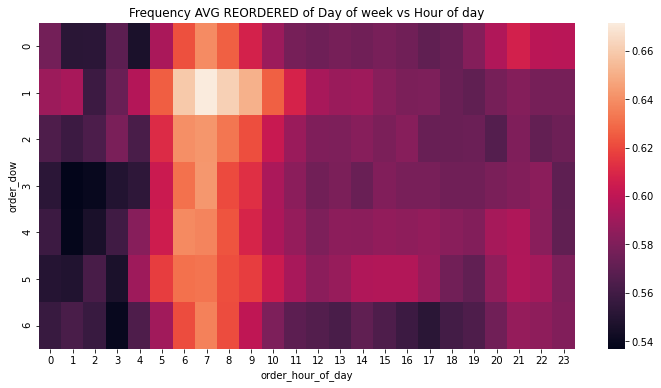

In [59]:
# merge customer past orders (order_prod_prior) & order in-depth details (orders)
orderprodprior_orders = pd.merge(order_prod_prior, orders, on='order_id', how='left')

# group data by order_dow, order_hour_of_day, and get average of reordered
grouped_df = orderprodprior_orders.groupby(['order_dow', 'order_hour_of_day'])['reordered'].aggregate('mean').reset_index()
grouped_df.head(3)
display(grouped_df)
grouped= grouped_df
# turn it to heatmap-suited format, by pivot it
grouped_df = grouped_df.pivot('order_dow', 'order_hour_of_day', 'reordered')
grouped_df.head(3)

# display result in heatmap 
plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Frequency AVG REORDERED of Day of week vs Hour of day")
plt.show()


# highest on Sunday between 6am to 9am (nice)
# in general, for any days, highest between 5am to 9am
# interpretation : 0.66 means, 66% of all orders are actually reorders (returning customers)

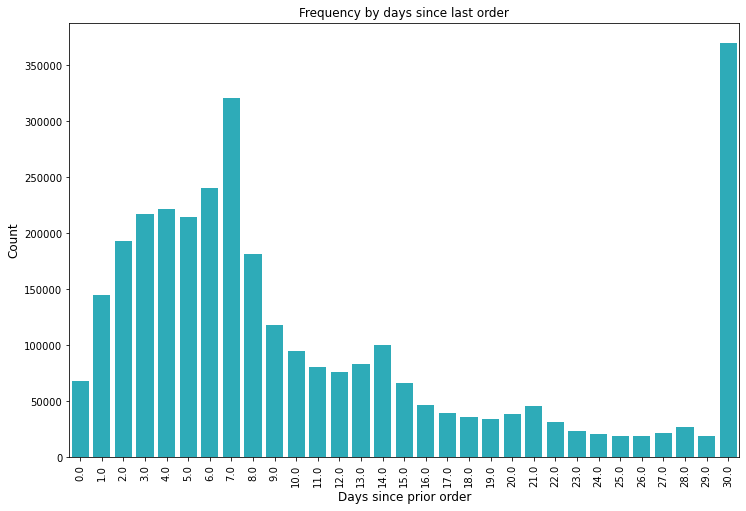

In [60]:
# Days since prior order column given
plt.figure(figsize=(12,8))
sns.countplot(x='days_since_prior_order', data=orders, color=color[9])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency by days since last order")
plt.show()

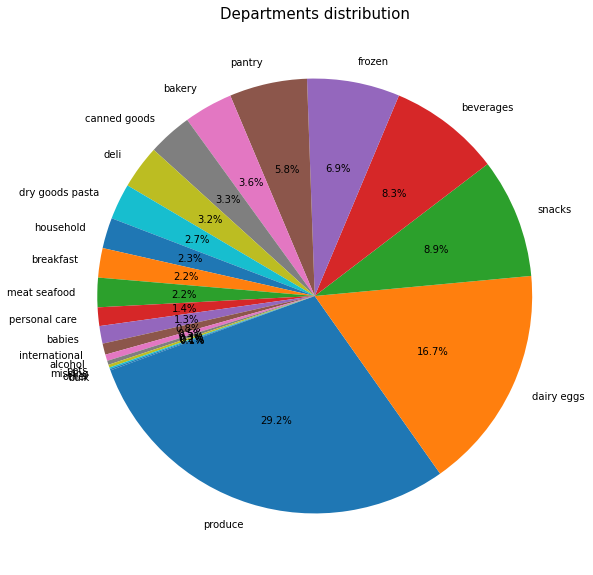

produce            0.292260
dairy eggs         0.166922
snacks             0.089027
beverages          0.082940
frozen             0.068952
pantry             0.057827
bakery             0.036282
canned goods       0.032930
deli               0.032411
dry goods pasta    0.026719
household          0.022774
breakfast          0.021877
meat seafood       0.021857
personal care      0.013785
babies             0.013066
international      0.008301
alcohol            0.004739
pets               0.003013
missing            0.002132
other              0.001119
bulk               0.001066
Name: department, dtype: float64

In [61]:
# department에 따른 비율
plt.figure(figsize=(10,10))
temp_series = all_join['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
plt.pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
plt.title("Departments distribution", fontsize=15)
plt.show()
temp_series['Percentage']= temp_series/sum(temp_series)
temp_series['Percentage']

## Analysis

### Manipulate Train, Test data

In [90]:
# new df
new_df = data_1.merge(orders_future, on='user_id', how='inner')
print(new_df.columns)

Index(['user_id', 'product_id', 'Times_Bought_N', 'total_orders',
       'uxp_reorder_ratio', 'u_reordered', 'product_total_purchases',
       'p_reorder_ratio', 'eval_set_x', 'order_id_x', 'order_hour_of_day',
       'order_dow', 'days_since_prior_order', 'department_id', 'aisle_id',
       'mean_position', 'dept_reorder_rate', 'aisle_reorder_rate',
       'dow_rordered', 'dow_aisle_rordered', 'dow_dept_rordered',
       'dept_percentage', 'dow_hour_reorder', 'product_reordered_dow',
       'prod_reordered_hod', 'prod_reordered_dpo', 'day_reorder_rate',
       'hour_reorder_rate', 'p_days_since_prior_order_reorder_rate',
       'days_since_prior_reorder_rate', 'eval_set_y', 'order_id_y'],
      dtype='object')


,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,eval_set_x,order_id_x,...,dow_hour_reorder,product_reordered_dow,prod_reordered_hod,prod_reordered_dpo,day_reorder_rate,hour_reorder_rate,p_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate,eval_set_y,order_id_y
0,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.585931,0.768907,0.773451,0.010952,0.152580,0.078930,0.010952,0.1,train,1187899
1,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.576301,0.773050,0.769180,0.017854,0.153642,0.085217,0.017854,0.1,train,1187899
2,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.651143,0.818099,0.808148,0.014194,0.214272,0.113157,0.014194,0.1,train,1187899
3,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.636844,0.768907,0.786026,0.007320,0.152580,0.019195,0.007320,0.1,train,1187899
4,1,196,10,10,1.000000,0.694915,35791,0.776480,train,1187899,...,0.579219,0.818099,0.756458,0.027744,0.214272,0.068146,0.027744,0.1,train,1187899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434484,206209,44325,1,13,0.142857,0.472868,3485,0.401148,train,272231,...,0.579582,0.422917,0.408000,0.041320,0.137733,0.071736,0.041320,1.0,train,272231
32434485,206209,48370,1,13,0.333333,0.472868,3934,0.699288,train,272231,...,0.594672,0.692149,0.725000,0.094814,0.123030,0.091510,0.094814,1.0,train,272231
32434486,206209,48697,1,13,0.142857,0.472868,9783,0.357661,train,272231,...,0.579582,0.354680,0.343137,0.032301,0.124502,0.083410,0.032301,1.0,train,272231
32434487,206209,48742,2,13,0.285714,0.472868,1723,0.498549,train,272231,...,0.579582,0.433962,0.453846,0.034823,0.123041,0.075450,0.034823,0.5,train,272231


In [91]:
new_df = new_df.rename(columns = {'eval_set_x': 'eval_set', 'order_id_x': 'order_id'})
new_df = new_df.drop(['eval_set_y', 'order_id_y'], axis=1)
new_df.head()

In [106]:
# Get train data and test data
train_data = new_df[new_df.eval_set=='train']
test_data = new_df[new_df.eval_set=='test']
# Get from order_prod_train all the products that the train users bought bought in their future order
train_data = train_data.merge(order_prod_train[['product_id','order_id', 'reordered']], on=['product_id','order_id'], how='left' )
train_data

## Group by 'user_id', 'product_id'
- All number of orders with counting each products: 3.2million -> groupby user_id and product reduce to -> 1.3 million
1. Without this grouping prediciton model will predict same products over and over.
    | user_id | product_id | x1~xn|
    |---------|------------|------|
    | 1 | 196 | n1 |
    | 1 | 196 | n2 |
    | 1 | 196 | n3 |
    | 1 | 196 | n4... |
2. Variables that will change are only categorical data. <br/>
We can still use numerical data because these are the means of the grouped data

In [107]:
# 1. All number of orders with counting each products: 32 million -> groupby user_id and product reduce to -> 1.3 million
# 이렇게 user_id와 product_id로 groupby 해야 중복 데이터를 없앨수 있다.
# 2. variable that will changes are only categorical data. We can still use numerical data because these are the mean of the grouped data
train_data = train_data.groupby(['user_id', 'product_id']).mean().reset_index()
test_data = test_data.groupby(['user_id', 'product_id']).mean().reset_index()

In [108]:
train_data

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,order_id,order_hour_of_day,...,dept_percentage,dow_hour_reorder,product_reordered_dow,prod_reordered_hod,prod_reordered_dpo,day_reorder_rate,hour_reorder_rate,p_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate,reordered
0,1,196,10.0,10.0,1.000000,0.694915,35791.0,0.776480,1187899.0,10.300000,...,0.082940,0.616088,0.789892,0.784557,0.025839,0.174049,0.060945,0.028613,0.100000,1.0
1,1,10258,9.0,10.0,1.000000,0.694915,1946.0,0.713772,1187899.0,10.555556,...,0.089027,0.614221,0.732247,0.737162,0.027692,0.189563,0.062693,0.027692,0.111111,1.0
2,1,10326,1.0,10.0,0.166667,0.694915,5526.0,0.652009,1187899.0,15.000000,...,0.292260,0.585931,0.626277,0.684343,0.008143,0.123959,0.071661,0.008143,1.000000,NaN
3,1,12427,10.0,10.0,1.000000,0.694915,6476.0,0.740735,1187899.0,10.300000,...,0.089027,0.616088,0.758102,0.766233,0.021155,0.187400,0.062662,0.023657,0.100000,NaN
4,1,13032,3.0,10.0,0.333333,0.694915,3751.0,0.657158,1187899.0,8.000000,...,0.021877,0.639044,0.686708,0.671031,0.045588,0.168400,0.070204,0.045588,0.333333,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,206209,43961,3.0,13.0,0.300000,0.472868,55371.0,0.630583,272231.0,13.000000,...,0.292260,0.599179,0.635898,0.622220,0.036439,0.157718,0.074823,0.036439,0.333333,NaN
8474657,206209,44325,1.0,13.0,0.142857,0.472868,3485.0,0.401148,272231.0,13.000000,...,0.026719,0.579582,0.422917,0.408000,0.041320,0.137733,0.071736,0.041320,1.000000,NaN
8474658,206209,48370,1.0,13.0,0.333333,0.472868,3934.0,0.699288,272231.0,10.000000,...,0.022774,0.594672,0.692149,0.725000,0.094814,0.123030,0.091510,0.094814,1.000000,NaN
8474659,206209,48697,1.0,13.0,0.142857,0.472868,9783.0,0.357661,272231.0,13.000000,...,0.057827,0.579582,0.354680,0.343137,0.032301,0.124502,0.083410,0.032301,1.000000,NaN


In [109]:
#Where the previous merge, left a NaN value on reordered column means that the customers they haven't bought the product. We change the value on them to 0.
train_data['reordered'] = train_data['reordered'].fillna(0)
train_data.head(15)

,user_id,product_id,Times_Bought_N,total_orders,uxp_reorder_ratio,u_reordered,product_total_purchases,p_reorder_ratio,order_id,order_hour_of_day,...,dept_percentage,dow_hour_reorder,product_reordered_dow,prod_reordered_hod,prod_reordered_dpo,day_reorder_rate,hour_reorder_rate,p_days_since_prior_order_reorder_rate,days_since_prior_reorder_rate,reordered
0,1,196,10.0,10.0,1.000000,0.694915,35791.0,0.776480,1187899.0,10.300000,...,0.082940,0.616088,0.789892,0.784557,0.025839,0.174049,0.060945,0.028613,0.100000,1.0
1,1,10258,9.0,10.0,1.000000,0.694915,1946.0,0.713772,1187899.0,10.555556,...,0.089027,0.614221,0.732247,0.737162,0.027692,0.189563,0.062693,0.027692,0.111111,1.0
2,1,10326,1.0,10.0,0.166667,0.694915,5526.0,0.652009,1187899.0,15.000000,...,0.292260,0.585931,0.626277,0.684343,0.008143,0.123959,0.071661,0.008143,1.000000,0.0
3,1,12427,10.0,10.0,1.000000,0.694915,6476.0,0.740735,1187899.0,10.300000,...,0.089027,0.616088,0.758102,0.766233,0.021155,0.187400,0.062662,0.023657,0.100000,0.0
4,1,13032,3.0,10.0,0.333333,0.694915,3751.0,0.657158,1187899.0,8.000000,...,0.021877,0.639044,0.686708,0.671031,0.045588,0.168400,0.070204,0.045588,0.333333,1.0
5,1,13176,2.0,10.0,0.222222,0.694915,379450.0,0.832555,1187899.0,11.000000,...,0.292260,0.614309,0.832284,0.847051,0.012514,0.118718,0.056217,0.012514,0.500000,0.0
6,1,14084,1.0,10.0,0.100000,0.694915,15935.0,0.810982,1187899.0,8.000000,...,0.166922,0.632893,0.797424,0.837288,0.000000,0.126702,0.055538,0.012112,0.000000,0.0
7,1,17122,1.0,10.0,0.166667,0.694915,13880.0,0.675576,1187899.0,15.000000,...,0.292260,0.585931,0.689820,0.666968,0.008790,0.120317,0.079611,0.008790,1.000000,0.0
8,1,25133,8.0,10.0,1.000000,0.694915,6196.0,0.740155,1187899.0,11.000000,...,0.166922,0.610662,0.749316,0.756781,0.020860,0.160083,0.066434,0.020860,0.125000,1.0
9,1,26088,2.0,10.0,0.200000,0.694915,2523.0,0.539041,1187899.0,7.500000,...,0.089027,0.637790,0.503519,0.558712,0.011891,0.126437,0.036465,0.020214,0.250000,1.0


## Check Top features (corr>10%)

Index(['Times_Bought_N', 'uxp_reorder_ratio', 'product_total_purchases',
       'p_reorder_ratio', 'mean_position', 'dept_reorder_rate',
       'aisle_reorder_rate', 'dow_aisle_rordered', 'dow_dept_rordered',
       'product_reordered_dow', 'prod_reordered_hod',
       'days_since_prior_reorder_rate', 'reordered'],
      dtype='object')


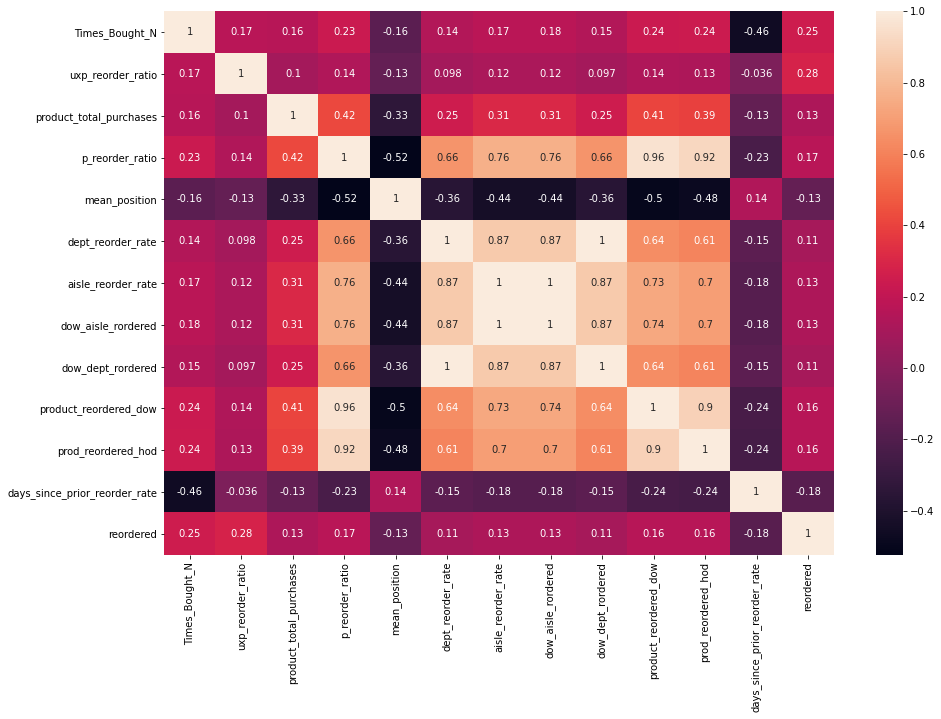

,Feature 1,Feature 2,Correlation Coefficient
29,reordered,reordered,1.000000
144,reordered,uxp_reorder_ratio,0.281601
154,reordered,Times_Bought_N,0.248376
189,reordered,days_since_prior_reorder_rate,0.177737
198,reordered,p_reorder_ratio,0.167360
203,reordered,product_reordered_dow,0.164952
211,reordered,prod_reordered_hod,0.162503
244,reordered,aisle_reorder_rate,0.130652
246,reordered,dow_aisle_rordered,0.130531
255,reordered,mean_position,0.129354


In [113]:
# 상관계수가 10% 이상인 종목만
cor = train_data.corr()
top_feature = cor.index[abs(cor['reordered']) >= 0.1]
print(top_feature)
top_corr = train_data[top_feature].corr()
plt.figure(figsize=(15,10))
sns.heatmap(top_corr, annot=True)
plt.xticks(rotation=90)
plt.show()

# corelation 확인
df_all_corr = train_data.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'reordered']

In [116]:
top_df=train_data[top_feature]
top_df

,Times_Bought_N,uxp_reorder_ratio,product_total_purchases,p_reorder_ratio,mean_position,dept_reorder_rate,aisle_reorder_rate,dow_aisle_rordered,dow_dept_rordered,product_reordered_dow,prod_reordered_hod,days_since_prior_reorder_rate,reordered
0,10.0,1.000000,35791.0,0.776480,3.721774,0.653460,0.638832,0.651159,0.659752,0.789892,0.784557,0.100000,1.0
1,9.0,1.000000,1946.0,0.713772,4.277492,0.574180,0.519170,0.531387,0.578379,0.732247,0.737162,0.111111,1.0
2,1.0,0.166667,5526.0,0.652009,4.191097,0.649913,0.718104,0.720980,0.656404,0.626277,0.684343,1.000000,0.0
3,10.0,1.000000,6476.0,0.740735,4.760037,0.574180,0.591986,0.598729,0.578165,0.758102,0.766233,0.100000,0.0
4,3.0,0.333333,3751.0,0.657158,5.622767,0.560922,0.571584,0.572207,0.562591,0.686708,0.671031,0.333333,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8474656,3.0,0.300000,55371.0,0.630583,9.194723,0.649913,0.638514,0.638814,0.653955,0.635898,0.622220,0.333333,0.0
8474657,1.0,0.142857,3485.0,0.401148,10.109900,0.461076,0.453062,0.446837,0.454189,0.422917,0.408000,1.000000,0.0
8474658,1.0,0.333333,3934.0,0.699288,8.344942,0.402178,0.528005,0.539190,0.407662,0.692149,0.725000,1.000000,0.0
8474659,1.0,0.142857,9783.0,0.357661,8.763058,0.346721,0.350843,0.357642,0.350453,0.354680,0.343137,1.000000,0.0


## All of the features used

In [118]:
# TRAIN FULL 

###########################
## IMPORT REQUIRED PACKAGES
###########################
import xgboost
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
train_data.loc[:, 'reordered'] = train_data.reordered.fillna(0)

########################################
## SPLIT DF TO: X_train, y_train (axis=1)
########################################
X_train, X_val, y_train, y_val = train_test_split(train_data.drop('reordered', axis=1), train_data.reordered,
                                                    test_size=0.2, random_state=42)

### 1. Normal params
- This is the one I really used

[0]	train-logloss:0.51212
[10]	train-logloss:0.25402
[20]	train-logloss:0.25045
[30]	train-logloss:0.24954
[40]	train-logloss:0.24873
[50]	train-logloss:0.24799
[60]	train-logloss:0.24734
[70]	train-logloss:0.24667
[80]	train-logloss:0.24601
[90]	train-logloss:0.24544
[99]	train-logloss:0.24496


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

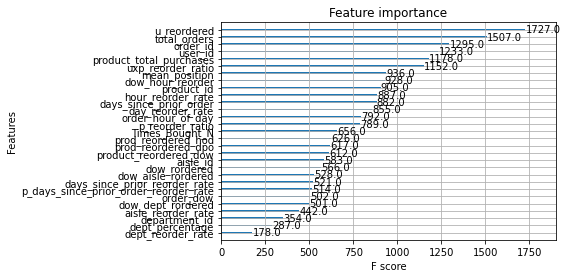

In [119]:
############################
## INITIATE AND TRAIN MODEL
############################

# Model1
d_train = xgboost.DMatrix(X_train, y_train, enable_categorical=True) # let categorical vaiable works

xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
#     ,"eta"              : 0.1
    ,"max_depth"        : 8
#     ,"min_child_weight" :10
#     ,"gamma"            :0.70
#     ,"subsample"        :0.76
#     ,"colsample_bytree" :0.95
#     ,"alpha"            :2e-05
#     ,"lambda"           :10
}
watchlist= [(d_train, "train")]
# verbose eval: 몇번째마다 출력할지
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=100, evals=watchlist, verbose_eval=10, early_stopping_rounds = 80)
# Use this plot_importance for feature extraction
xgboost.plot_importance(bst)

### 2. Max depth manipulation
- max_depth 8 had the best outcome

In [ ]:
# depth check
depth_list = [4,5,6,7,8]
n_estimators_list = [100,200,300]
learning_rate_list= []
d_train = xgboost.DMatrix(X_train, y_train)

watchlist= [(d_train, "train")]
model_list = []
for dl in depth_list:
    xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : dl
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
    }
    xgb = xgb_params
    xgb_t =xgboost.train(params=xgb, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
    model_list.append(xgb_t)
    xgboost.plot_importance(xgb_t)
check_acc=[]
check_precision=[]
check_f1=[]

for idx, i in enumerate(model_list):
    pred_result=(i.predict(val_pred)> 0.5).astype(int)
    print(idx)
    check_acc.append([idx,format(accuracy_score(y_val, pred_result))])
    check_precision.append([idx,format(precision_score(y_val, pred_result))])
    check_f1.append([idx, format(f1_score(y_val, pred_result))])

    print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_val, pred_result)))
    print('XGBoost model precision_score score: {0:0.4f}'. format(precision_score(y_val, pred_result)))
    print('XGBoost model f1 score: {0:0.4f}'. format(f1_score(y_val, pred_result)))

### 3. GridSearchCV
#### Problems
1. Memory problem (How do I solve it?)

In [ ]:
# Gridsearchcv
from sklearn.model_selection import StratifiedKFold
model = xgboost.XGBClassifier(objective='binary:logistic', eval_metric='logloss', num_boost_round=10)


param_grid = {"max_depth" : [6,8],
            "colsample_bytree" : [0.3, 0.4],
            "learning_rate" : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold) # cv 제외후 돌리기
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
pyplot.errorbar(learning_rate, means, yerr=stds)
pyplot.title("XGBoost learning_rate vs Log Loss")
pyplot.xlabel('learning_rate')
pyplot.ylabel('Log Loss')
pyplot.savefig('learning_rate.png')

## Validation

In [126]:
val_pred = xgboost.DMatrix(X_val)
val_prediction = X_val.reset_index()
val_prediction = val_prediction[['product_id', 'user_id']]
val_prediction["reordered"] = (bst.predict(val_pred)> 0.50).astype(int)

In [127]:
orders_val = orders[orders.eval_set=='train']
val_prediction = val_prediction.merge(orders_val[["user_id", "order_id"]], on='user_id', how='left')
val_prediction

,product_id,user_id,reordered,order_id
0,5428,133414,1,2252239
1,49099,107612,0,422449
2,8021,69469,0,826633
3,6377,190574,0,1330981
4,17758,196693,0,2802722
...,...,...,...,...
1694928,39275,145083,0,1825460
1694929,27247,192880,0,3015332
1694930,47141,138840,0,1315167
1694931,23395,47309,0,2533828


In [128]:
val_prediction['product_id'] = val_prediction.product_id.astype(int)
val_prediction = val_prediction.drop('user_id', axis=1)
gc.collect()
val_prediction

,product_id,reordered,order_id
0,5428,1,2252239
1,49099,0,422449
2,8021,0,826633
3,6377,0,1330981
4,17758,0,2802722
...,...,...,...
1694928,39275,0,1825460
1694929,27247,0,3015332
1694930,47141,0,1315167
1694931,23395,0,2533828


In [129]:
d_val = dict()
for row in val_prediction.itertuples():
    if row.reordered == 1:
        try:
            d_val[row.order_id] += ' ' + str(row.product_id)
        except:
            d_val[row.order_id] = str(row.product_id)

for order in val_prediction.order_id:
    if order not in d_val:
        d_val[order] = 'None'
        
gc.collect()

47

In [130]:
#Convert the dictionary into a DataFrame
sub_val = pd.DataFrame.from_dict(d_val, orient='index')

#Reset index
sub_val.reset_index(inplace=True)
#Set column names
sub_val.columns = ['order_id', 'products']

sub_val.head()

,order_id,products
0,2252239,5428 47209
1,1486426,32211 5422
2,1144310,27845
3,933936,16797 21903
4,1883268,47626 28289 23986 21903 329


## Model Accuracy

In [131]:
from sklearn.metrics import *
print('XGBoost model accuracy score: {0:0.4f}'. format(accuracy_score(y_val, val_prediction['reordered'])))
print('XGBoost model precision_score score: {0:0.4f}'. format(precision_score(y_val, val_prediction['reordered'])))
print('XGBoost model f1 score: {0:0.4f}'. format(f1_score(y_val, val_prediction['reordered'])))

XGBoost model accuracy score: 0.9079
XGBoost model precision_score score: 0.6253
XGBoost model f1 score: 0.2442


## Test

In [132]:
pred = xgboost.DMatrix(test_data)

prediction = test_data.reset_index()
prediction = prediction[['product_id', 'user_id']]

prediction["reordered"] = (bst.predict(pred) > 0.15).astype(int)

In [133]:
orders_test = orders[orders.eval_set=='test']
prediction = prediction.merge(orders_test[["user_id", "order_id"]], on='user_id', how='left')
prediction

,product_id,user_id,reordered,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,1,2774568
3,7503,3,0,2774568
4,8021,3,0,2774568
...,...,...,...,...
4833287,48364,206208,0,803273
4833288,48865,206208,0,803273
4833289,49247,206208,0,803273
4833290,49385,206208,0,803273


In [134]:
prediction['product_id'] = prediction.product_id.astype(int)
prediction = prediction.drop('user_id', axis=1)
gc.collect()
prediction

,product_id,reordered,order_id
0,248,0,2774568
1,1005,0,2774568
2,1819,1,2774568
3,7503,0,2774568
4,8021,0,2774568
...,...,...,...
4833287,48364,0,803273
4833288,48865,0,803273
4833289,49247,0,803273
4833290,49385,0,803273


In [135]:
d = dict()
for row in prediction.itertuples():
    if row.reordered == 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in prediction.order_id:
    if order not in d:
        d[order] = 'None'
        
gc.collect()

47

In [136]:
#Convert the dictionary into a DataFrame
sub = pd.DataFrame.from_dict(d, orient='index')

#Reset index
sub.reset_index(inplace=True)
#Set column names
sub.columns = ['order_id', 'products']

sub.head()

,order_id,products
0,2774568,1819 9387 16797 17668 18599 21903 22035 39190 ...
1,1528013,8424 21903 38293
2,1376945,4799 8309 8670 13176 14947 17706 20383 24799 2...
3,1356845,7076 10863 11520 13176 14992 30489
4,2161313,196 10441 11266 12427 14715 27839 37710


In [ ]:
sub.head()

In [138]:
sub.to_csv('submission.csv', index=False)

### Manipulate Product name
- Still working on it

In [139]:
# product name으로 확인
name_list = list(all_join['product_name'])

def get_normalized_words (s):
    assert type(s) is str
    return normalize_string(s).split()

# name_list = get_normalized_words(name_list)
# name_list
def normalize_string(s):
    assert type (s) is str
    return ''.join([c for c in s.lower() if c.isalpha() or c.isspace()])

for i in range(len(name_list)):
    name_list[i] = normalize_string(name_list[i])

In [140]:
name_list[:10]

['organic egg whites',
 'michigan organic kale',
 'garlic powder',
 'coconut butter',
 'natural sweetener',
 'carrots',
 'original unflavored gelatine mix',
 'all natural no stir creamy almond butter',
 'classic blend cole slaw',
 'total  with strawberry lowfat greek strained yogurt']

In [ ]:
name_all = []
for i in name_list:
    for j in i.split():
        if j not in name_all:
            name_all.append(j)


In [ ]:
name_all[:10]